In [ ]:
!pip install -Uq transformers
!pip install -U --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/ triton-nightly

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.2/138.2 MB 15.8 MB/s eta 0:00:00


config.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Benchmarking without torch.compile...
Average inference time without torch.compile: 0.0056 seconds

Benchmarking with torch.compile...
Average inference time with torch.compile: 0.0037 seconds


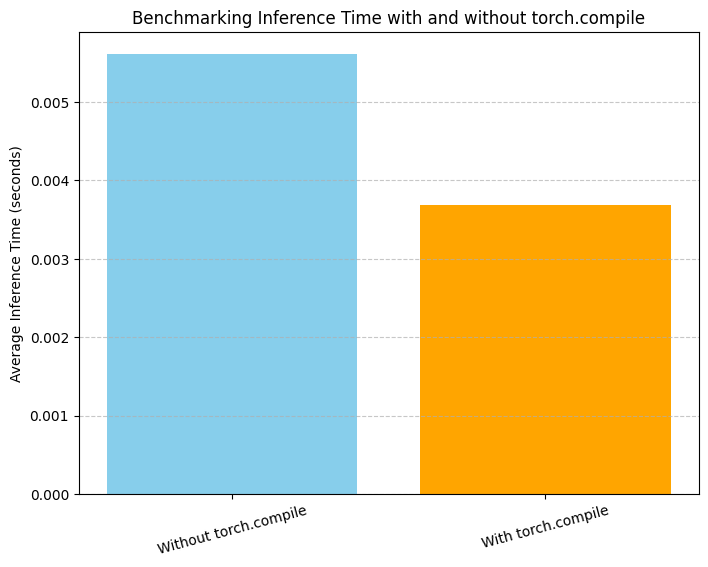

In [ ]:
from transformers import AutoModelForImageClassification, AutoImageProcessor
from transformers.image_utils import load_image
import torch
import time
import matplotlib.pyplot as plt

torch.set_float32_matmul_precision("high")

# Load image
image_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/timm/cat.jpg"
image = load_image(image_url)

# Define checkpoint and load model
checkpoint = "timm/vit_base_patch16_224.augreg2_in21k_ft_in1k"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForImageClassification.from_pretrained(checkpoint).to(device)

# Prepare input
processed_input = image_processor(image, return_tensors="pt").to(device)

# Function to warm up and benchmark model
def run_benchmark(model, input_data, warmup_runs=5, benchmark_runs=300):
    # Warm-up phase
    model.eval()
    with torch.no_grad():
        for _ in range(warmup_runs):
            _ = model(**input_data)

    # Benchmark phase
    times = []
    with torch.no_grad():
        for _ in range(benchmark_runs):
            start_time = time.time()
            _ = model(**input_data)
            times.append(time.time() - start_time)

    avg_time = sum(times) / benchmark_runs
    return avg_time

# 🚀 Benchmark without torch.compile
print("Benchmarking without torch.compile...")
time_without_compile = run_benchmark(model, processed_input)
print(f"Average inference time without torch.compile: {time_without_compile:.4f} seconds")

# 🚀 Benchmark with torch.compile
print("\nBenchmarking with torch.compile...")
compiled_model = torch.compile(model).to(device)
time_with_compile = run_benchmark(compiled_model, processed_input)
print(f"Average inference time with torch.compile: {time_with_compile:.4f} seconds")

# Plot the results
times = [time_without_compile, time_with_compile]
labels = ["Without torch.compile", "With torch.compile"]

plt.figure(figsize=(8, 6))
plt.bar(labels, times, color=["skyblue", "orange"])
plt.ylabel("Average Inference Time (seconds)")
plt.title("Benchmarking Inference Time with and without torch.compile")
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()